In [17]:
!pip install PyDrive
# https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from PIL import Image

from glob import glob, iglob

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader
import math
from torchvision import transforms

import torchvision.transforms.functional as TF

In [0]:
# authorize Google SDK to access Google Drive from Colab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def get_and_unzip_file(id, zip_name):
  # Enable link sharing for the file. Copy the link. Get id.
  download = drive.CreateFile({'id': id})
  download.GetContentFile(zip_name) 

In [20]:
# get_and_unzip_file('1LJh_oF3sU3fbucRDpRYmkpCe5FpwrGRT', 'widerface_subset.tar')
# get_and_unzip_file('1bbgdcNRyXT6Jz5IoQ1egJvFkMTnB-kbC', 'vgg2_subset.tar')
# get_and_unzip_file('1BiO6XVRY9Ou3tve2DZmm1Sm8xtTjAD5h', 'testset.tar')
# get_and_unzip_file('1r5wZLOD3pMdUkxdXE7SJyPy7gXsM2dn5', 'test_res.tar')
# get_and_unzip_file('1lAtyrKWQsktOcUeOV_tjbl1ltUi63v9h', 'fa_subset.tar')
# get_and_unzip_file('1DEl-afZ6B0VZ5r2X_HCyNaVDK0uiCs_x', 'celea_subset.tar')
get_and_unzip_file('1b-4ICO-MAaxBrJeTrYMqD8lbLWjYquA8', 'try_img.zip')

# train_HR : vggface2/vggcrop_train_1p10, vggface2/vggcrop_test_1p10, SRtrainset_2, celea_60000_SFD
# train_LR : wider_lnew
# test_HR : test_res
# test_LR : testset
# !tar -xvf widerface_subset.tar #wider_lnew
# !tar -xvf vgg2_subset.tar # vggface2/vggcrop_train_1p10, vggface2/vggcrop_test_1p10
# !tar -xvf fa_subset.tar # SRtrainset_2
# !tar -xvf celea_subset.tar # celea_60000_SFD
# !tar -xvf testset.tar # testset
# !tar -zcvf try_img.tar.gz try_img # try_img
!unzip try_img.zip

Archive:  try_img.zip
replace try_img/000008.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000008.jpg      
replace try_img/000009.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000009.jpg      
replace try_img/000012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000012.jpg      
replace try_img/000006.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000006.jpg      
replace try_img/000004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000004.jpg      
replace try_img/000011.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000011.jpg      
replace try_img/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: try_img/000001.jpg      


In [21]:
# !rm -rf try_img
os.listdir('try_img')

['000004.jpg',
 '000011.jpg',
 '000006.jpg',
 '000012.jpg',
 '000001.jpg',
 '000008.jpg',
 '000009.jpg']

In [0]:
# train_HR : vggface2/vggcrop_train_1p10(345756), vggface2/vggcrop_test_1p10(20048), SRtrainset_2(31556), celea_60000_SFD(60000)
# train_LR : wider_lnew(53254)
# test_HR : test_res(2999)
# test_LR : testset(2999)

# def get_n_files(path):
#   return len(next(os.walk(path))[-1])
# get_n_files("SRtrainset_2")

# get number of files by linux
# !ls -1 vggface2/vggcrop_train_lp10 wc -l

In [0]:
class my_dataset(data.Dataset):
    def __init__(self, dir_path, transform):
        self.transform = transform
        self.dir_path = dir_path
        self.img_list = os.listdir(dir_path)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img_raw = Image.open(self.dir_path + "/" + self.img_list[index])
        width, height = img_raw.size
        return self.transform(img_raw)

def get_loader(bs = 4):
    transform = transforms.Compose([
            transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = my_dataset("try_img", transform)
    data_loader = DataLoader(dataset=dataset,
                             batch_size=bs,
                             shuffle=False, num_workers=2, pin_memory=True)
    return data_loader

In [0]:
try_ds = get_loader()

# for i in range(len(try_ds)):
#   print(try_ds[i])

In [27]:
# get some random training images
dataiter = iter(try_ds)
images = dataiter.next()
print(images.shape)

torch.Size([4, 3, 64, 64])


In [0]:
def conc_noise(x):
  x = x.reshape([-1, 12288])
  noise = torch.randn(x.shape[0], 64)
  x = torch.cat((x, noise), 1)
  # a fully connected layer to reshape to have the same size as one image channel
  x = nn.Linear(12352, 12288)(x)
  x = x.reshape([-1, 3, 64, 64])
  return x

In [239]:
x = images
x = conc_noise(x)
x.shape

torch.Size([4, 3, 64, 64])

In [217]:
class H2L_G_block(nn.Module):
    def __init__(self, inplanes, planes, downsample=False, upsample=False):
        super(H2L_G_block, self).__init__() # input shape (3, 64, 64)
        self.upsample = upsample
        self.downsample = downsample
        
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, inplanes, 3, 1, 1) # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True  # wd_out = ((width - filter width + 2 padding) / stride) + 1
        self.bn2 = nn.BatchNorm2d(inplanes)
        
        if self.upsample:
          self.skip = nn.Sequential(nn.Conv2d(inplanes, planes, 1, 1), nn.PixelShuffle(2))
        elif self.downsample:
          self.skip = nn.Sequential(nn.Conv2d(inplanes, planes, 1, 1), nn.AvgPool2d(2,2)) #kernel_size=2, stride=2  # or nn.MaxPool2d(2, 2)
        else:
          self.skip = nn.Conv2d(inplanes, planes, 1)

    def forward(self, x):
        residual = x
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x += residual
        x = self.skip(x)
        return x

# net1 = H2L_G_block(3, 256, downsample=True)
# net2 = H2L_G_block(256, 512, downsample=True)
# net3 = H2L_G_block(512, 1024, downsample=True)
# net4 = H2L_G_block(1024, 2048, downsample=True)
# net5 = H2L_G_block(2048, 2048, upsample=True)
# net6 = H2L_G_block(512, 512, upsample=True)
gp1 = nn.Sequential(H2L_G_block(3, 256, downsample=True), H2L_G_block(256, 256))
gp2 = nn.Sequential(H2L_G_block(256, 512, downsample=True), H2L_G_block(512, 512))
gp3 = nn.Sequential(H2L_G_block(512, 1024, downsample=True), H2L_G_block(1024, 1024))
gp4 = nn.Sequential(H2L_G_block(1024, 2048, downsample=True), H2L_G_block(2048, 2048))
gp5 = nn.Sequential(H2L_G_block(2048, 2048, upsample=True), H2L_G_block(512, 512))
gp6 = nn.Sequential(H2L_G_block(512, 512, upsample=True), H2L_G_block(128, 3))
# x_ = gp1(x)
# print(x_.shape)
# x_ = gp2(x_)
# print(x_.shape)
# x_ = gp3(x_)
# print(x_.shape)
# x_ = gp4(x_)
# print(x_.shape)
# x_ = gp5(x_)
# print(x_.shape)
# x_ = gp6(x_)
# print(x_.shape)
# total_net = nn.Sequential(net1, net2, net3, net4, net5, net6)
# x_ = total_net(x)

H2L_G = nn.Sequential(gp1, gp2, gp3, gp4, gp5, gp6)
x_ = H2L_G(x)
print(x_.shape)


torch.Size([4, 3, 16, 16])


In [218]:
import torch.optim as optim
import numpy as np

criterion = nn.CrossEntropyLoss() # test
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #test

  
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(try_ds, 0):
        # get the inputs
        inputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = H2L_G(inputs)
        print(outputs.shape)

print('Finished Training')

torch.Size([4, 3, 16, 16])
torch.Size([3, 3, 16, 16])
torch.Size([4, 3, 16, 16])
torch.Size([3, 3, 16, 16])
Finished Training


In [236]:
class H2L_D_block(nn.Module):
    def __init__(self, inplanes, planes, downsample=False):
        super(H2L_D_block, self).__init__() # input shape (3, 16, 16)
        self.downsample = downsample
        
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, inplanes, 3, 1, 1) # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True  # wd_out = ((width - filter width + 2 padding) / stride) + 1
        
        if self.downsample:
          self.skip = nn.Sequential(nn.Conv2d(inplanes, planes, 1, 1), nn.MaxPool2d(2,2)) #kernel_size=2, stride=2  
        else:
          self.skip = nn.Conv2d(inplanes, planes, 1)

    def forward(self, x):
        residual = x
        x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        x += residual
        x = self.skip(x)
        return x

net1 = H2L_D_block(3, 256)
net2 = H2L_G_block(256, 256)
net3 = H2L_G_block(256, 256)
net4 = H2L_G_block(256, 256)
net5 = H2L_G_block(256, 128, downsample=True)
net6 = H2L_G_block(128, 96, downsample=True)

# x_ = net1(outputs)
# print(x_.shape)
# x_ = net2(x_)
# print(x_.shape)
# x_ = net3(x_)
# print(x_.shape)
# x_ = net4(x_)
# print(x_.shape)
# x_ = net5(x_)
# print(x_.shape)
# x_ = net6(x_)
# print(x_.shape)

H2L_D = nn.Sequential(net1, net2, net3, net4, net5, net6)

x_ = H2L_D(outputs)
print(x_.shape)


torch.Size([3, 96, 4, 4])


In [237]:
criterion = nn.CrossEntropyLoss() # test
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #test

  
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(try_ds, 0):
        # get the inputs
        inputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = H2L_D(inputs)
        print(outputs.shape)

print('Finished Training')

torch.Size([4, 96, 16, 16])
torch.Size([3, 96, 16, 16])
torch.Size([4, 96, 16, 16])
torch.Size([3, 96, 16, 16])
Finished Training


In [0]:
def display_img(file_path):
  im = Image.open(file_path)
  wd, ht = im.size
  print(wd, ht)
  display(im)

64 64


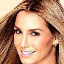

In [0]:
display_img("try_img/000001.jpg")

In [0]:
#tf
# def dir_path_to_nor_tensor(dir_path):
#     res = []
#     for i in os.listdir(dir_path):
#         img_raw = tf.read_file(dir_path + "/" + i)
#         img_tensor = tf.cast(tf.image.decode_image(img_raw), tf.float32)
#         nor_tensor = tf.math.divide(tf.math.subtract(img_tensor, tf.constant(127.5)), tf.constant(127.5))
#         res.append(nor_tensor)
#     return res

In [0]:
def dir_path_to_nor_tensor(dir_path):
    res = []
    for i in os.listdir(dir_path):
        img_raw = Image.open(dir_path + "/" + i)
        width, height = img_raw.size
        channel = 3 if img_raw.mode == 'RGB' else 1        
#         transform = transforms.Compose([transforms.Resize(width * height * channel)])        
        transform = transforms.Compose([transforms.Resize(width * height * channel), transforms.ToTensor(),  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])        
#         img_tensor = TF.to_tensor(img_raw).reshape([-1, width * height * channel])
#         nor_tensor = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img_tensor)
        nor_tensor = transform(img_raw)
        res.append(nor_tensor)
        break
    return res

In [0]:
img_ts = dir_path_to_nor_tensor("try_img")

In [0]:
## 20190419


image = Image.open("SRtrainset_2/64_2000_3707.jpg")
width, height = image.size
channel = 3 if image.mode == 'RGB' else 1
print(width, height, channel)
img = TF.to_tensor(image).reshape([-1, 12288])
img.shape

FileNotFoundError: ignored

In [0]:
noise = torch.randn(1, 64)
input = torch.cat((img, noise), 1)
input.shape
# a fully connected layer to reshape to have the same size as one image channel
input = nn.Linear(12352, 12288)(input)
input.reshape([64, 64, 3])